In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## load data

In [15]:
folder_path="/its/home/drs25/Documents/GitHub/pico_weight_scales/assets/data"
def load_and_label_sensor_csvs(folder_path):
    all_dfs = []

    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, header=None)
            df.rename(columns={0: file.replace("grams_","").replace(".csv","")}, inplace=True)
            if type(all_dfs)==type([]):
                all_dfs=df
            else: all_dfs=pd.concat([all_dfs, df], axis=1)
    return all_dfs
df = load_and_label_sensor_csvs(folder_path)
if df is not None:
    print(df.head())    

         20        40        90        60       110        10        30  \
0  0.017725  0.019336  0.023365  0.020142  0.020948  0.014502  0.017725   
1  0.015308  0.016919  0.022559  0.020948  0.020948  0.016919  0.018530   
2  0.015308  0.019336  0.025782  0.021753  0.023365  0.014502  0.017725   
3  0.015308  0.020142  0.026587  0.021753  0.021753  0.013697  0.019336   
4  0.015308  0.019336  0.026587  0.020948  0.021753  0.014502  0.017725   

         80        50        70       100  
0  0.023365  0.019336  0.020142  0.024170  
1  0.014502  0.016919  0.020142  0.023365  
2  0.021753  0.017725  0.020948  0.016919  
3  0.024170  0.017725  0.026587  0.024170  
4  0.023365  0.016919  0.013697  0.024170  


## show data

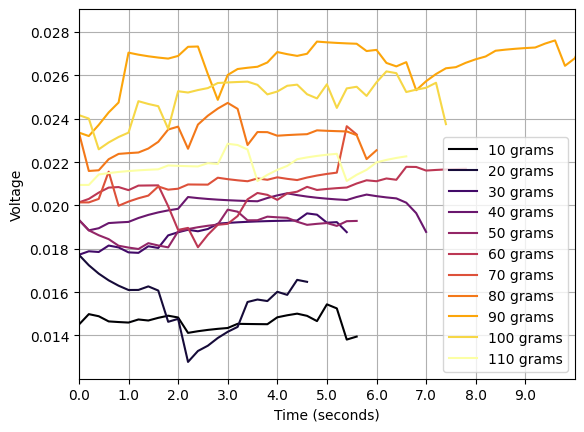

In [31]:
def low_pass(data,alpha=0.8):
    ar=[data[0]]
    for i in range(1,len(data)-1):
        ar.append(alpha*ar[i-1] + (1-alpha)*data[i])
    return ar
keys=list(df.keys())
keys = sorted(keys, key=int)
colors = plt.cm.inferno(np.linspace(0, 1, len(keys)))  # Generate colors
for i in range(len(keys)):
    key=keys[i]
    plt.plot(low_pass(df[key]),label=key+" grams", color=colors[i])

plt.ylabel("Voltage")
plt.xlim([0,50])
plt.xticks([i for i in range(0,50,5)],[0.2*i for i in range(0,50,5)])
plt.grid(1)
plt.xlabel("Time (seconds)")
plt.legend(loc="lower right")
plt.show()